# Bootstrap for A/B Testing


---

## Part 1: Introduction to Bootstrap

### What is Bootstrap?

Bootstrap is a resampling technique that allows us to estimate the sampling distribution of a statistic by repeatedly sampling **with replacement** from our original data.

**The Key Idea:** We treat our sample as if it were the entire population, then repeatedly resample from it to understand sampling variability.

### Why Do We Need Bootstrap?

1. **No distributional assumptions**: Works with any distribution
2. **Small samples**: Makes the most of limited data
3. **Complex statistics**: Can handle statistics where formulas don't exist
4. **Practical**: We often only have one sample

Let's start with the necessary imports:

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings


# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)  # For reproducibility

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Part 2: Understanding the Concept

Let's start with a simple example. Imagine we have a sample of customer satisfaction scores and want to understand the uncertainty in our mean estimate.

In [28]:
# Original sample: customer satisfaction scores (1-10 scale)
satisfaction_scores = np.array([7, 8, 6, 9, 7, 8, 5, 7, 8, 9, 6, 7, 8, 7, 9])

print(f"Original sample size: {len(satisfaction_scores)}")
print(f"Sample mean: {np.mean(satisfaction_scores):.2f}")
print(f"Sample values: {satisfaction_scores}")

Original sample size: 15
Sample mean: 7.40
Sample values: [7 8 6 9 7 8 5 7 8 9 6 7 8 7 9]


### Step 1: Understanding Resampling with Replacement

The core of bootstrap is resampling **with replacement**. This means:
- We can pick the same value multiple times
- Each resample has the same size as the original sample

In [29]:
# Let's create ONE bootstrap resample
n = len(satisfaction_scores)
bootstrap_sample_1 = np.random.choice(satisfaction_scores, size=n, replace=True)

print("Original sample:")
print(satisfaction_scores)
print(f"Mean: {np.mean(satisfaction_scores):.2f}")
print("\nBootstrap resample:")
print(bootstrap_sample_1)
print(f"Mean: {np.mean(bootstrap_sample_1):.2f}")


Original sample:
[7 8 6 9 7 8 5 7 8 9 6 7 8 7 9]
Mean: 7.40

Bootstrap resample:
[5 9 8 9 6 7 8 7 5 9 6 5 6 6 7]
Mean: 6.87


### Step 2: Many Bootstrap Resamples

The power of bootstrap comes from creating MANY resamples. Each gives us a slightly different estimate, and together they show us the variability.

In [7]:
# Create many bootstrap resamples and calculate their means
n_bootstrap = 10000
bootstrap_means = []

for i in range(n_bootstrap):
    # Create a resample
    resample = np.random.choice(satisfaction_scores, size=n, replace=True)
    # Calculate and store its mean
    bootstrap_means.append(np.mean(resample))

bootstrap_means = np.array(bootstrap_means)

print(f"Generated {n_bootstrap} bootstrap means")
print(f"First 10 bootstrap means: {bootstrap_means[:10].round(2)}")

Generated 10000 bootstrap means
First 10 bootstrap means: [7.4  7.4  7.07 7.8  7.67 7.73 7.53 7.67 7.73 7.73]


### Step 3: Visualizing the Bootstrap Distribution

The distribution of bootstrap statistics approximates the sampling distribution!

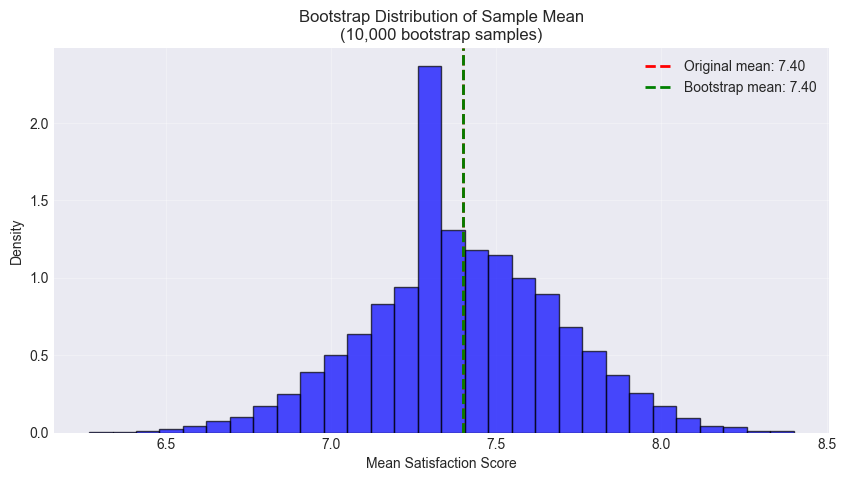


Bootstrap Standard Error: 0.298


In [30]:
# Visualize the bootstrap distribution
plt.figure(figsize=(10, 5))

plt.hist(bootstrap_means, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(np.mean(satisfaction_scores), color='red', linestyle='--', linewidth=2, 
            label=f'Original mean: {np.mean(satisfaction_scores):.2f}')
plt.axvline(np.mean(bootstrap_means), color='green', linestyle='--', linewidth=2,
            label=f'Bootstrap mean: {np.mean(bootstrap_means):.2f}')

plt.xlabel('Mean Satisfaction Score')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Sample Mean\n(10,000 bootstrap samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nBootstrap Standard Error: {np.std(bootstrap_means):.3f}")

## Part 3: Bootstrap Confidence Intervals

One of the most powerful applications of bootstrap is creating confidence intervals without assuming normality.

### The Percentile Method

The simplest approach: use the percentiles of the bootstrap distribution as confidence bounds.

In [10]:
def bootstrap_confidence_interval(data, statistic_func=np.mean, confidence=0.95, n_bootstrap=10000):
    """
    Calculate bootstrap confidence interval for any statistic.
    
    Parameters:
    - data: original sample
    - statistic_func: function to calculate statistic (default: mean)
    - confidence: confidence level (default: 0.95 for 95% CI)
    - n_bootstrap: number of bootstrap samples
    
    Returns:
    - lower_bound, upper_bound, bootstrap_distribution
    """
    n = len(data)
    bootstrap_statistics = []
    
    # Generate bootstrap samples and calculate statistics
    for _ in range(n_bootstrap):
        resample = np.random.choice(data, size=n, replace=True)
        bootstrap_statistics.append(statistic_func(resample))
    
    bootstrap_statistics = np.array(bootstrap_statistics)
    
    # Calculate confidence interval using percentile method
    alpha = 1 - confidence
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100
    
    lower_bound = np.percentile(bootstrap_statistics, lower_percentile)
    upper_bound = np.percentile(bootstrap_statistics, upper_percentile)
    
    return lower_bound, upper_bound, bootstrap_statistics

# Test with our satisfaction scores
lower, upper, boot_dist = bootstrap_confidence_interval(satisfaction_scores)

print(f"Sample mean: {np.mean(satisfaction_scores):.3f}")
print(f"95% Bootstrap Confidence Interval: [{lower:.3f}, {upper:.3f}]")
print(f"\nInterpretation: We're 95% confident the true mean satisfaction")
print(f"score lies between {lower:.3f} and {upper:.3f}")

Sample mean: 7.400
95% Bootstrap Confidence Interval: [6.800, 8.000]

Interpretation: We're 95% confident the true mean satisfaction
score lies between 6.800 and 8.000


### Comparing Different Statistics

Let's compare bootstrap for three statistics, mean, median, and standard deviation:

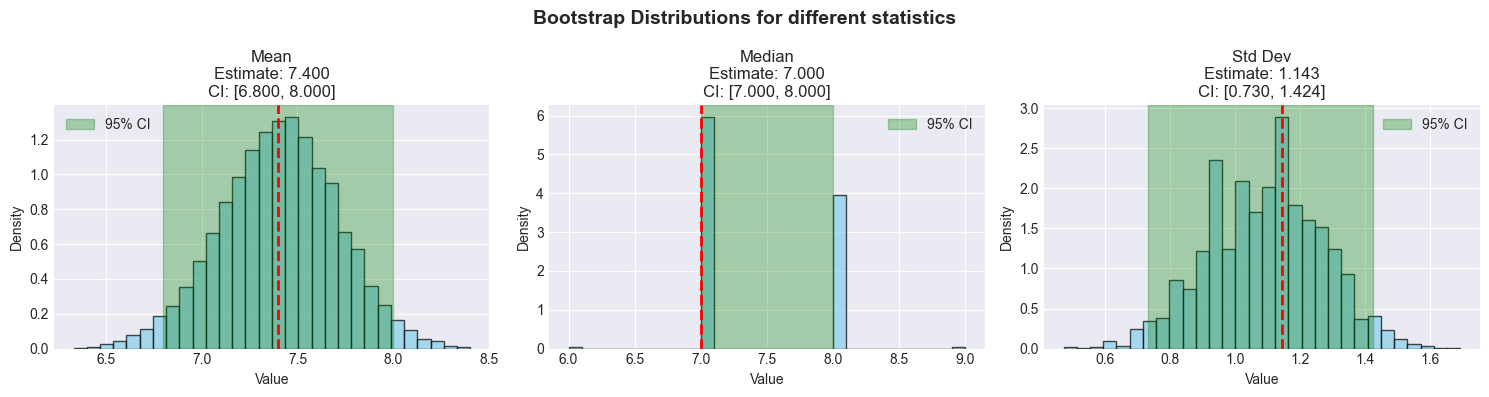

In [31]:
# Compare confidence intervals for different statistics
statistics_to_compare = [
    ('Mean', np.mean),
    ('Median', np.median),
    ('Std Dev', np.std)
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, stat_func) in enumerate(statistics_to_compare):
    lower, upper, boot_dist = bootstrap_confidence_interval(
        satisfaction_scores, statistic_func=stat_func
    )
    
    # Calculate point estimate
    point_estimate = stat_func(satisfaction_scores)
    
    # Plot
    axes[idx].hist(boot_dist, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    axes[idx].axvline(point_estimate, color='red', linestyle='--', linewidth=2)
    axes[idx].axvspan(lower, upper, alpha=0.3, color='green', label='95% CI')
    axes[idx].set_title(f'{name}\nEstimate: {point_estimate:.3f}\nCI: [{lower:.3f}, {upper:.3f}]')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

plt.suptitle('Bootstrap Distributions for different statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 4: Introduction to A/B Testing

Now let's apply bootstrap to a practical problem: **A/B testing** for website optimization.

### The Scenario

- **Website A** (Control): Current design with ~12% conversion rate
- **Website B** (Treatment): New design - does it improve conversions?

**Conversion** = visitor makes a purchase (1) or doesn't (0)

In [32]:
def generate_ab_data(n_a=1000, n_b=1000, conv_rate_a=0.12, conv_rate_b=0.15):
    """
    Simulate conversion data for A/B test.
    1 = converted (made purchase)
    0 = didn't convert
    """
    group_a = np.random.binomial(1, conv_rate_a, n_a)
    group_b = np.random.binomial(1, conv_rate_b, n_b)
    return group_a, group_b

# Generate data for our A/B test
np.random.seed(42)
group_a, group_b = generate_ab_data(n_a=1500, n_b=1500, 
                                    conv_rate_a=0.12, conv_rate_b=0.14)

# Calculate observed statistics
conv_rate_a = np.mean(group_a)
conv_rate_b = np.mean(group_b)
observed_difference = conv_rate_b - conv_rate_a

print("A/B Test Results:")
print("="*50)
print(f"Group A: {len(group_a)} visitors, {np.sum(group_a)} conversions ({conv_rate_a:.3f} rate)")
print(f"Group B: {len(group_b)} visitors, {np.sum(group_b)} conversions ({conv_rate_b:.3f} rate)")
print(f"\nObserved difference (B - A): {observed_difference:.3f}")
print(f"\nQuestion: Is this {observed_difference:.3f} difference real or just random chance?")

A/B Test Results:
Group A: 1500 visitors, 183 conversions (0.122 rate)
Group B: 1500 visitors, 202 conversions (0.135 rate)

Observed difference (B - A): 0.013

Question: Is this 0.013 difference real or just random chance?


## Part 5: Bootstrap for A/B Testing

### Method 1: Confidence Intervals for Each Group

First, let's calculate confidence intervals for each group's conversion rate:

Bootstrap Confidence Intervals (95%):
Group A: [0.1060, 0.1387]
Group B: [0.1180, 0.1520]

Do the intervals overlap? Yes


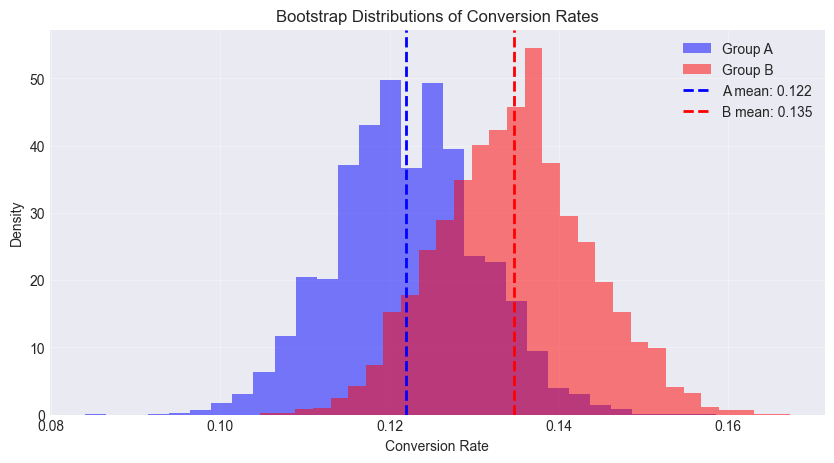

In [33]:
# Calculate bootstrap confidence intervals for each group
ci_a_lower, ci_a_upper, dist_a = bootstrap_confidence_interval(group_a)
ci_b_lower, ci_b_upper, dist_b = bootstrap_confidence_interval(group_b)

print("Bootstrap Confidence Intervals (95%):")
print("="*50)
print(f"Group A: [{ci_a_lower:.4f}, {ci_a_upper:.4f}]")
print(f"Group B: [{ci_b_lower:.4f}, {ci_b_upper:.4f}]")
print(f"\nDo the intervals overlap? {['No', 'Yes'][ci_a_upper > ci_b_lower]}")

# Visualize
plt.figure(figsize=(10, 5))

# Plot distributions
plt.hist(dist_a, bins=30, alpha=0.5, label='Group A', color='blue', density=True)
plt.hist(dist_b, bins=30, alpha=0.5, label='Group B', color='red', density=True)

# Add means
plt.axvline(conv_rate_a, color='blue', linestyle='--', linewidth=2, label=f'A mean: {conv_rate_a:.3f}')
plt.axvline(conv_rate_b, color='red', linestyle='--', linewidth=2, label=f'B mean: {conv_rate_b:.3f}')

plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.title('Bootstrap Distributions of Conversion Rates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Method 2: Permutation Test (Bootstrap Hypothesis Testing)

To test if the difference is statistically significant, we use a permutation test:
- **Null Hypothesis (H₀)**: No difference between groups
- **Alternative**: Group B has different conversion rate than Group A

Under H₀, we can shuffle the group labels and the difference should be similar.

In [34]:
def permutation_test(group_a, group_b, n_permutations=10000):
    """
    Perform permutation test to check if difference between groups is significant.
    """
    n_a = len(group_a)
    n_b = len(group_b)
    
    # Combine all data
    combined = np.concatenate([group_a, group_b])
    
    # Calculate observed difference
    observed_diff = np.mean(group_b) - np.mean(group_a)
    
    # Generate null distribution by permutation
    permuted_diffs = []
    
    for _ in range(n_permutations):
        # Shuffle the combined data
        shuffled = np.random.permutation(combined)
        
        # Split into two groups of same sizes
        perm_a = shuffled[:n_a]
        perm_b = shuffled[n_a:]
        
        # Calculate difference
        perm_diff = np.mean(perm_b) - np.mean(perm_a)
        permuted_diffs.append(perm_diff)
    
    permuted_diffs = np.array(permuted_diffs)
    
    # Calculate p-value (two-sided test)
    p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))
    
    return observed_diff, permuted_diffs, p_value

# Perform the test
observed_diff, null_distribution, p_value = permutation_test(group_a, group_b)

print("Permutation Test Results:")
print("="*50)
print(f"Observed difference: {observed_diff:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant at alpha=0.05? {['No', 'Yes'][p_value < 0.05]}")

if p_value < 0.05:
    print("\n Conclusion: The new design (B) has a significantly different conversion rate!")
else:
    print("\n Conclusion: No significant difference detected between designs.")

Permutation Test Results:
Observed difference: 0.0127
P-value: 0.3182
Significant at alpha=0.05? No

 Conclusion: No significant difference detected between designs.


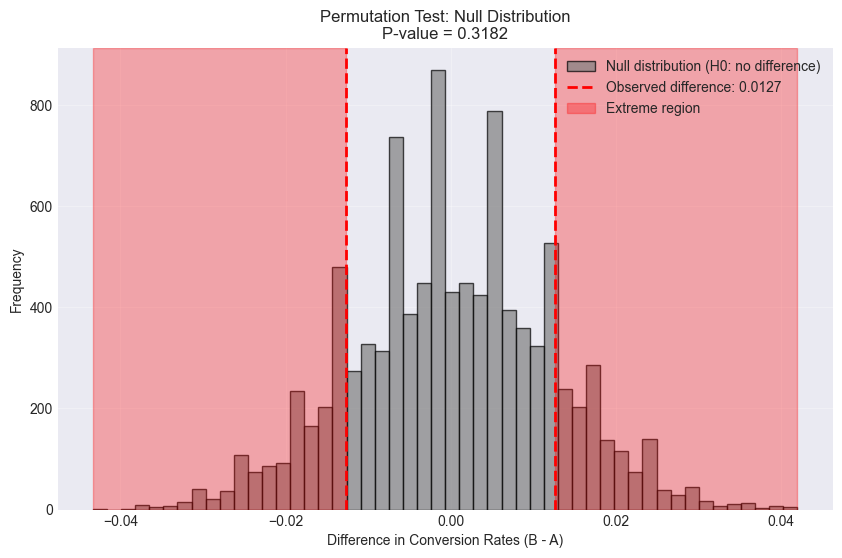


Interpretation: Only 31.82% of random shuffles produce
a difference as extreme as 0.0127


In [35]:
# Visualize the permutation test
plt.figure(figsize=(10, 6))

plt.hist(null_distribution, bins=50, alpha=0.7, color='gray', edgecolor='black', 
         label='Null distribution (H0: no difference)')
plt.axvline(observed_diff, color='red', linestyle='--', linewidth=2, 
            label=f'Observed difference: {observed_diff:.4f}')
plt.axvline(-observed_diff, color='red', linestyle='--', linewidth=2)

# Shade extreme regions
extreme_threshold = np.abs(observed_diff)
plt.axvspan(extreme_threshold, null_distribution.max(), alpha=0.3, color='red', label='Extreme region')
plt.axvspan(null_distribution.min(), -extreme_threshold, alpha=0.3, color='red')

plt.xlabel('Difference in Conversion Rates (B - A)')
plt.ylabel('Frequency')
plt.title(f'Permutation Test: Null Distribution\nP-value = {p_value:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nInterpretation: Only {p_value*100:.2f}% of random shuffles produce")
print(f"a difference as extreme as {observed_diff:.4f}")

## Part 6: When Bootstrap Fails - Non-Smooth Statistics

Bootstrap works well for **smooth statistics** (mean, median, variance) but can fail for **non-smooth statistics** like the maximum.

### Why Does Bootstrap Fail for Maximum?

1. Maximum is not a smooth functional of the distribution
2. Bootstrap can't generate values beyond the observed maximum
3. Small changes in distribution cause discontinuous jumps in maximum

Let's demonstrate this:

In [36]:
# Generate data from Uniform[0, 10]
true_max = 10
n = 100
uniform_sample = np.random.uniform(0, true_max, n)

print(f"True maximum (theoretical): {true_max}")
print(f"Sample maximum: {np.max(uniform_sample):.3f}")
print(f"Sample median: {np.median(uniform_sample):.3f}")

True maximum (theoretical): 10
Sample maximum: 9.877
Sample median: 4.640


In [21]:
def compare_bootstrap_performance(data, n_bootstrap=5000):
    """
    Compare bootstrap performance for median (smooth) vs maximum (non-smooth).
    """
    n = len(data)
    
    # Bootstrap distributions
    bootstrap_medians = []
    bootstrap_maxes = []
    
    for _ in range(n_bootstrap):
        resample = np.random.choice(data, size=n, replace=True)
        bootstrap_medians.append(np.median(resample))
        bootstrap_maxes.append(np.max(resample))
    
    return np.array(bootstrap_medians), np.array(bootstrap_maxes)

# Generate bootstrap distributions
boot_medians, boot_maxes = compare_bootstrap_performance(uniform_sample)

# Calculate confidence intervals
median_ci = np.percentile(boot_medians, [2.5, 97.5])
max_ci = np.percentile(boot_maxes, [2.5, 97.5])

print("Bootstrap Results:")
print("="*50)
print(f"Median - Sample value: {np.median(uniform_sample):.3f}")
print(f"Median - 95% CI: [{median_ci[0]:.3f}, {median_ci[1]:.3f}]")
print(f"Median - True value (5.0) in CI? {median_ci[0] <= 5.0 <= median_ci[1]}")
print()
print(f"Maximum - Sample value: {np.max(uniform_sample):.3f}")
print(f"Maximum - 95% CI: [{max_ci[0]:.3f}, {max_ci[1]:.3f}]")
print(f"Maximum - True value (10.0) in CI? {max_ci[0] <= 10.0 <= max_ci[1]}")
print("\n Notice: Bootstrap CI for maximum fails to include true value!")

Bootstrap Results:
Median - Sample value: 4.640
Median - 95% CI: [3.947, 5.320]
Median - True value (5.0) in CI? True

Maximum - Sample value: 9.877
Maximum - 95% CI: [9.279, 9.877]
Maximum - True value (10.0) in CI? False

 Notice: Bootstrap CI for maximum fails to include true value!


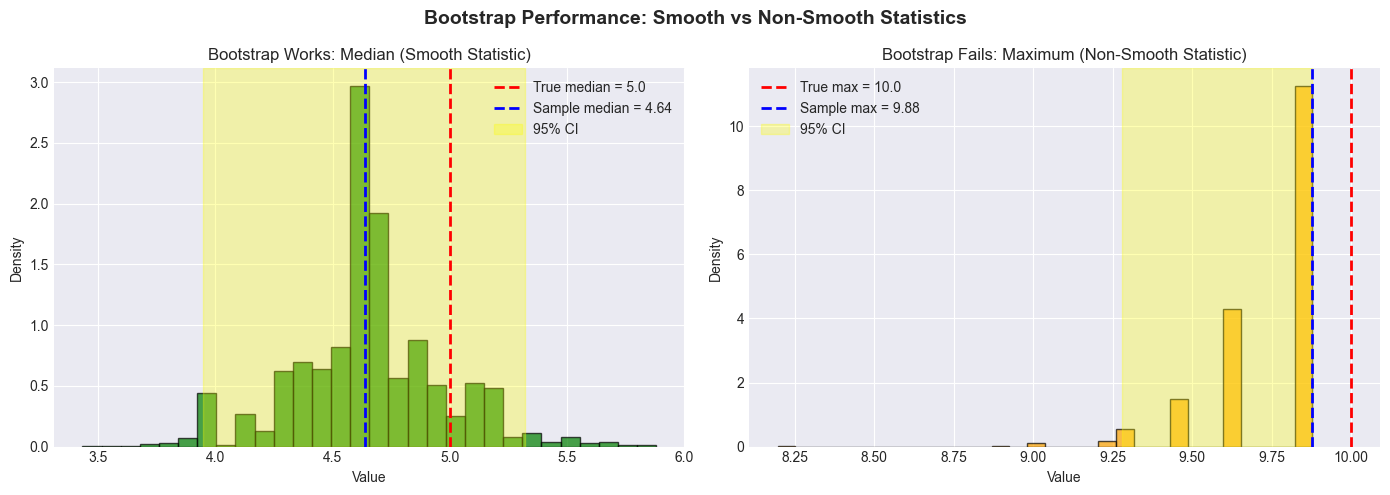

In [26]:
# Visualize the problem
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Median (works well)
axes[0].hist(boot_medians, bins=30, density=True, alpha=0.7, color='green', edgecolor='black')
axes[0].axvline(5.0, color='red', linestyle='--', linewidth=2, label='True median = 5.0')
axes[0].axvline(np.median(uniform_sample), color='blue', linestyle='--', linewidth=2, 
                label=f'Sample median = {np.median(uniform_sample):.2f}')
axes[0].axvspan(median_ci[0], median_ci[1], alpha=0.3, color='yellow', label='95% CI')
axes[0].set_title('Bootstrap Works: Median (Smooth Statistic)')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot 2: Maximum (fails)
axes[1].hist(boot_maxes, bins=30, density=True, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(10.0, color='red', linestyle='--', linewidth=2, label='True max = 10.0')
axes[1].axvline(np.max(uniform_sample), color='blue', linestyle='--', linewidth=2,
                label=f'Sample max = {np.max(uniform_sample):.2f}')
axes[1].axvspan(max_ci[0], max_ci[1], alpha=0.3, color='yellow', label='95% CI')
axes[1].set_title('Bootstrap Fails: Maximum (Non-Smooth Statistic)')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.suptitle('Bootstrap Performance: Smooth vs Non-Smooth Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

